<h1>Содержание<span class="tocSkip"></span></h1>

* [Описание проекта](#Описание) 
* [Даныные и общая информация](#Данные) 
* [Подготовка данных к исследованию](#Подготовка)   
* [Подсчет помесячной выручки от каждого пользователя](#Выручка)
* [Анализ поведения пользователей для каждого тарифа](#Поведение) 
* [Проверка гипотез](#Гипотезы)    
* [Выводы](#Выводы)


## Описание проекта  <a id='Описание'></a>

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна». Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов:**

- Тариф «Смарт»
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
    * минута разговора: 3 рубля
    * сообщение: 3 рубля
    * 1 Гб интернет-трафика: 200 рублей
    
**Тариф «Ультра»**

- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
    * минута разговора: 1 рубль
    * сообщение: 1 рубль
    * 1 Гб интернет-трафика: 150 рублей


## Данные и общая информация <a id='Данные'></a>

In [1]:
#импортируем библиотеки:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st


#прочитаем предоставленные csv-таблицы:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

###### 1) Таблица calls (информация о звонках):

In [2]:
display(calls.head())
calls.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [3]:
#поправим форматы значений:
calls = calls.astype({'id':'int'},errors='ignore')
calls['call_date'] = pd.to_datetime(
    calls['call_date'], format='%Y-%m-%d'
)

###### Таблица internet (информация об интернет-сессиях):

In [4]:
display(internet.head())
internet.info()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [5]:
#в данноый таблице нашелся побочный столбец, повторяющий индексы. Отбросим его:
internet.drop(['Unnamed: 0'], axis=1, inplace=True)

#поправим форматы значений:
internet = internet.astype({'id':'int'},errors='ignore')
internet['session_date'] = pd.to_datetime(
    internet['session_date'], format='%Y-%m-%d'
)

###### Таблица messages (информация о сообщениях):

In [6]:
display(messages.head())
messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [7]:
#поправим форматы значений:
messages = messages.astype({'id':'int'},errors='ignore')
messages['message_date'] = pd.to_datetime(
    messages['message_date'], format='%Y-%m-%d'
)

###### Таблица tariffs (информация о тарифах):

In [8]:
display(tariffs)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


###### Таблица users (информация о пользователях):

In [9]:
display(users.head())
users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [10]:
#проверим, нет ли дубликатов в предоставленной таблице
print('Количество дубликатов в таблице:', users.duplicated().sum())

#поправим форматы значений:
users['churn_date'] = pd.to_datetime(
    users['churn_date'], format='%Y-%m-%d'
)
users['reg_date'] = pd.to_datetime(
    users['reg_date'], format='%Y-%m-%d'
)

print('Процент отключеных пользователей:', users[users['churn_date'].isna() == False]['user_id'].count()/users['user_id'].count()*100)

Количество дубликатов в таблице: 0
Процент отключеных пользователей: 7.6


7,6% пользователей на момент исследования не пользуются тарифом. Давайте проверим, как давно они "отвалились":

In [11]:
display(users[users['churn_date'].isna() == False])

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
19,1019,63,2018-10-05,Томск,Игнатий,Круглов,2018-05-16,ultra
20,1020,59,2018-12-18,Чита,Тала,Костина,2018-10-22,smart
34,1034,66,2018-11-21,Вологда,Святослав,Бондарев,2018-08-26,smart
50,1050,44,2018-10-03,Тюмень,Рузана,Аничкина,2018-06-16,ultra
51,1051,37,2018-10-14,Москва,Кристина,Сомова,2018-05-28,smart
56,1056,73,2018-10-14,Иркутск,Радислав,Артемьев,2018-04-13,smart
62,1062,24,2018-12-09,Москва,Александр,Коршунов,2018-11-16,smart
63,1063,45,2018-12-11,Тула,Таира,Климова,2018-04-12,ultra
64,1064,55,2018-12-26,Якутск,Динара,Алфеева,2018-03-17,smart
65,1065,53,2018-12-09,Москва,Роза,Игнатова,2018-03-08,smart


**Вывод**

Пользователи с отмененным тарифом, отказались от него не ранее сентября. Т.к. в дальнейшем мы будем исследовать данные по месяцам, то убирать этих пользователей не будем (как минимум 3/4 года данных по каждому есть).

Данные, после замены форматов, в общем, выглядят корректно, пропусков и дубликатов в данных о пользователях мы не обнаружили. 

## Подготовка данных к исследованию <a id='Подготовка'></a>

Т.к. далее все действия будут с усредненными данными по месяцам, сгруппируем текущие датасеты. 

In [12]:
#добавим колонку с месяцем:
calls['month'] = pd.DatetimeIndex(calls['call_date'].astype('datetime64[M]'))
internet['month'] = pd.DatetimeIndex(internet['session_date'].astype('datetime64[M]'))
messages['month'] = pd.DatetimeIndex(messages['message_date'].astype('datetime64[M]'))

#согласно тарифу, округление в большую сторону происходит для каждого совершенного звонка. Округлим звонки до минуты:
calls['duration'] = calls['duration'].apply(np.ceil)


#сгруппируем таблицы по user_id и месяцам, а так же посчитаем среднее для всех типов коммуникаций по месяцам: 
#звонки:
monthly_calls_count = calls.groupby(['user_id', 'month'])['duration'].count()
monthly_calls_duration = calls.groupby(['user_id', 'month'])['duration'].sum()

monthly_calls_count = pd.DataFrame(({'calls_count': monthly_calls_count})).reset_index()
monthly_calls_duration = pd.DataFrame(({'calls_duration': monthly_calls_duration})).reset_index()

monthly_calls=monthly_calls_count.merge(monthly_calls_duration, on=['user_id', 'month'], how='outer')


In [13]:
#интернет:
monthly_internet_count = internet.groupby(['user_id', 'month'])['mb_used'].sum()
monthly_internet = pd.DataFrame(({'internet_traffic': monthly_internet_count}))

#смс:
monthly_messages_count = messages.groupby(['user_id', 'month'])['message_date'].count()
monthly_messages = pd.DataFrame(({'masseges': monthly_messages_count}))


#объединим все таблицы в одну:
monthly_communications=monthly_calls.merge(monthly_internet, on=['user_id', 'month'], how='outer')
monthly_communications=monthly_communications.merge(monthly_messages, on=['user_id', 'month'], how='outer')

display(monthly_communications)

,user_id,month,calls_count,calls_duration,internet_traffic,masseges
0,1000,2018-05-01,22.0,159.0,2253.49,22.0
1,1000,2018-06-01,43.0,172.0,23233.77,60.0
2,1000,2018-07-01,47.0,340.0,14003.64,75.0
3,1000,2018-08-01,52.0,408.0,14055.93,81.0
4,1000,2018-09-01,58.0,466.0,14568.91,57.0
...,...,...,...,...,...,...
3209,1489,2018-08-01,NaN,NaN,11050.56,17.0
3210,1489,2018-09-01,NaN,NaN,17206.30,32.0
3211,1489,2018-10-01,NaN,NaN,19559.44,21.0
3212,1489,2018-11-01,NaN,NaN,17491.56,20.0


Благодаря объединению таблиц с параметром how='outer', мы получили пропуски в данных, которые говорят нам о том, что некоторые пользователи не пользовались теми или иными опциями связи. 

На всякий случай проверим, нет ли пользователей, которые не пользовались ни одним из способов связи. 

In [14]:
print(monthly_communications[
    (monthly_communications['calls_count'].isna() == True) &
    (monthly_communications['calls_duration'].isna() == True) &
    (monthly_communications['internet_traffic'].isna() == True) &
    (monthly_communications['masseges'].isna() == True)
])

Empty DataFrame
Columns: [user_id, month, calls_count, calls_duration, internet_traffic, masseges]
Index: []


Проверка подтверждает гипотезу, что разные пользователи могут предпочитать разные способы связи. Заменим на 0 пропуски в данных. 

In [15]:
#заменим на 0 пропуски в данных:
columns_to_update = ['calls_count', 'calls_duration', 'internet_traffic', 'masseges']

for i in columns_to_update:
    monthly_communications[i] = monthly_communications[i].fillna(0)

#в тарифах, округление происходит в большую сторону. Округлим минуты:
#monthly_communications['calls_duration'] = monthly_communications['calls_duration'].apply(np.ceil)

#переведем Мб в Гб:
monthly_communications['internet_traffic'] = monthly_communications['internet_traffic']/1024
#округлим Гб:
monthly_communications['internet_traffic'] = monthly_communications['internet_traffic'].apply(np.ceil)

display(monthly_communications)

,user_id,month,calls_count,calls_duration,internet_traffic,masseges
0,1000,2018-05-01,22.0,159.0,3.0,22.0
1,1000,2018-06-01,43.0,172.0,23.0,60.0
2,1000,2018-07-01,47.0,340.0,14.0,75.0
3,1000,2018-08-01,52.0,408.0,14.0,81.0
4,1000,2018-09-01,58.0,466.0,15.0,57.0
...,...,...,...,...,...,...
3209,1489,2018-08-01,0.0,0.0,11.0,17.0
3210,1489,2018-09-01,0.0,0.0,17.0,32.0
3211,1489,2018-10-01,0.0,0.0,20.0,21.0
3212,1489,2018-11-01,0.0,0.0,18.0,20.0


Проверим, нет ли аномальных выбросов в полученых данных

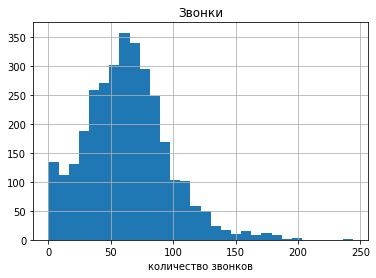

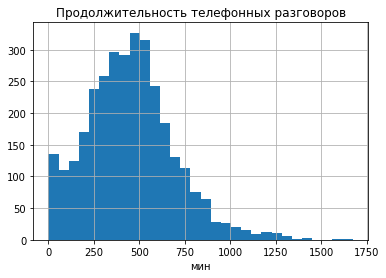

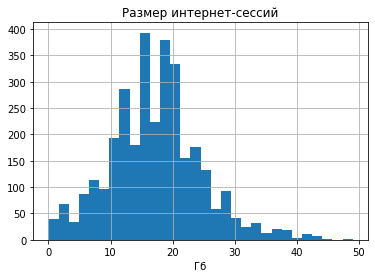

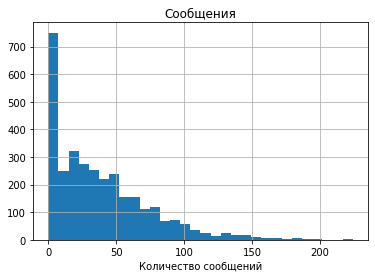

In [16]:
#построим гистограммы по каждому полученному типу коммуникации

monthly_communications['calls_count'].hist(bins=30).set_xlabel('количество звонков')
plt.title("Звонки")
plt.show()

monthly_communications['calls_duration'].hist(bins=30).set_xlabel('мин')
plt.title("Продолжительность телефонных разговоров")
plt.show()

monthly_communications['internet_traffic'].hist(bins=30).set_xlabel('Гб')
plt.title("Размер интернет-сессий")
plt.show()

monthly_communications['masseges'].hist(bins=30).set_xlabel('Количество сообщений')
plt.title("Сообщения")
plt.show()

Большинство данных распределено нормально. Есть особенность в распределении данных о сообщениях: в
них большое число нулей. Это, на самом деле похоже на правду: смс - это самый непопулярный канал связи(в текущий момент). 

## Подсчет ежемесячной выручки от каждого пользователя <a id='Выручка'></a>

In [17]:
#создадим таблицу с данными о количестве коммуникаций и информации о пользователе:
users_city_tariff = users[['user_id','city','tariff']]

monthly_user_communications = monthly_communications.merge(users_city_tariff, on='user_id')

In [18]:
#напишем функцию, которая посчитает прибыль по месяцам для каждого пользователя:

def revenue(row):
    calls_duration = row['calls_duration']
    masseges = row['masseges']
    internet = row['internet_traffic']
    tariff = row['tariff']
    
    if tariff == 'ultra':
        calls_cost = 0
        if calls_duration > 3000:
            calls_cost = (calls_duration - 3000)*1
        masseges_cost = 0
        
        if masseges > 1000:
            masseges_cost = (masseges - 3000)*1
        internet_cost = 0
        
        if internet > 30:
            internet_cost = (internet - 30)*150
        
        revenue = calls_cost + masseges_cost + internet_cost + 1950

    
    elif tariff == 'smart':
        calls_cost = 0
        if calls_duration > 500:
            calls_cost = (calls_duration - 500)*3
        masseges_cost = 0
        if masseges > 50:
            masseges_cost = (masseges - 50)*3
        internet_cost = 0
        if internet > 15:
            internet_cost = (internet - 15)*200
        revenue = calls_cost + masseges_cost + internet_cost + 550 
    
    return revenue
        
#применим нашу функцию к таблице:

monthly_user_communications['revenue'] = monthly_user_communications.apply(revenue, axis=1)

#посмотрим, что у нас вышло:
display(monthly_user_communications.head(10))

,user_id,month,calls_count,calls_duration,internet_traffic,masseges,city,tariff,revenue
0,1000,2018-05-01,22.0,159.0,3.0,22.0,Краснодар,ultra,1950.0
1,1000,2018-06-01,43.0,172.0,23.0,60.0,Краснодар,ultra,1950.0
2,1000,2018-07-01,47.0,340.0,14.0,75.0,Краснодар,ultra,1950.0
3,1000,2018-08-01,52.0,408.0,14.0,81.0,Краснодар,ultra,1950.0
4,1000,2018-09-01,58.0,466.0,15.0,57.0,Краснодар,ultra,1950.0
5,1000,2018-10-01,57.0,350.0,15.0,73.0,Краснодар,ultra,1950.0
6,1000,2018-11-01,43.0,338.0,15.0,58.0,Краснодар,ultra,1950.0
7,1000,2018-12-01,46.0,333.0,10.0,70.0,Краснодар,ultra,1950.0
8,1001,2018-11-01,59.0,430.0,18.0,0.0,Москва,smart,1150.0
9,1001,2018-12-01,63.0,414.0,14.0,0.0,Москва,smart,550.0


## Анализ поведения пользователей для каждого тарифа <a id='Поведение'></a>

Оценим количество пользователей в обоих тарифах:

In [19]:
print('Количество пользователей "ultra"', monthly_user_communications[monthly_user_communications['tariff'] == 'ultra']['calls_count'].count())
print('Количество пользователей "smart"', monthly_user_communications[monthly_user_communications['tariff'] == 'smart']['calls_count'].count())

Количество пользователей "ultra" 985
Количество пользователей "smart" 2229


У более бюджетного тарифа аудитория в два раза больше. 
Для того, чтоб достоверно сравнить их, будем опираться на медиану и 95 квантиль(примерно показывает максимальное значение в данных). 

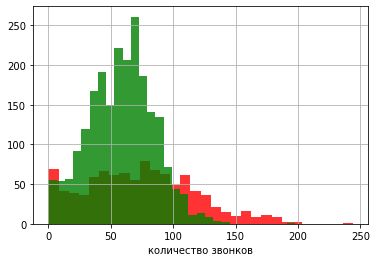

"ultra"
Медиана: 74.0
95-ый квантиль: 154
Среднее: 73
Дисперсия: 1927
Стандартное отклонение: 44

"smart"
Медиана: 60.0
95-ый квантиль: 99.0
Среднее: 58
Дисперсия: 673
Стандартное отклонение: 26


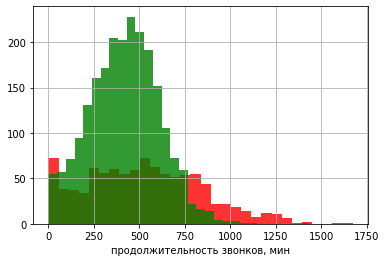

"smart"
Медиана: 518.0
95-ый квантиль: 1088.6
Среднее: 58
Дисперсия: 673
Стандартное отклонение: 26

"ultra"
Медиана: 518.0
95-ый квантиль: 1088.6
Среднее: 527
Дисперсия: 100771
Стандартное отклонение: 317


In [20]:
monthly_user_communications[monthly_user_communications['tariff'] == 'ultra']['calls_count'].hist(bins=30, alpha=0.8, color='r').set_xlabel('количество звонков')
monthly_user_communications[monthly_user_communications['tariff'] == 'smart']['calls_count'].hist(bins=30, alpha=0.8, color='g').set_xlabel('количество звонков')
plt.show()

print('"ultra"')
print('Медиана:', monthly_user_communications[monthly_user_communications['tariff'] == 'ultra']['calls_count'].median())
print('95-ый квантиль:', round(monthly_user_communications[monthly_user_communications['tariff'] == 'ultra']['calls_count'].quantile(0.95)))
print('Среднее:', round(monthly_user_communications[monthly_user_communications['tariff'] == 'ultra']['calls_count'].mean()))
print('Дисперсия:', round(np.var(monthly_user_communications[monthly_user_communications['tariff'] == 'ultra']['calls_count'])))
print('Стандартное отклонение:', round(np.std(monthly_user_communications[monthly_user_communications['tariff'] == 'ultra']['calls_count'])))


print()
print('"smart"')
print('Медиана:', monthly_user_communications[monthly_user_communications['tariff'] == 'smart']['calls_count'].median())
print('95-ый квантиль:', monthly_user_communications[monthly_user_communications['tariff'] == 'smart']['calls_count'].quantile(0.95))
print('Среднее:', round(monthly_user_communications[monthly_user_communications['tariff'] == 'smart']['calls_count'].mean()))
print('Дисперсия:', round(np.var(monthly_user_communications[monthly_user_communications['tariff'] == 'smart']['calls_count'])))
print('Стандартное отклонение:', round(np.std(monthly_user_communications[monthly_user_communications['tariff'] == 'smart']['calls_count'])))


monthly_user_communications[monthly_user_communications['tariff'] == 'ultra']['calls_duration'].hist(bins=30, alpha=0.8, color='r').set_xlabel('продолжительность звонков, мин')
monthly_user_communications[monthly_user_communications['tariff'] == 'smart']['calls_duration'].hist(bins=30, alpha=0.8, color='g').set_xlabel('продолжительность звонков, мин')
plt.show()


print('"smart"')
print('Медиана:', monthly_user_communications[monthly_user_communications['tariff'] == 'ultra']['calls_duration'].median())
print('95-ый квантиль:', monthly_user_communications[monthly_user_communications['tariff'] == 'ultra']['calls_duration'].quantile(0.95))
print('Среднее:', round(monthly_user_communications[monthly_user_communications['tariff'] == 'smart']['calls_count'].mean()))
print('Дисперсия:', round(np.var(monthly_user_communications[monthly_user_communications['tariff'] == 'smart']['calls_count'])))
print('Стандартное отклонение:', round(np.std(monthly_user_communications[monthly_user_communications['tariff'] == 'smart']['calls_count'])))
print()
print('"ultra"')
print('Медиана:', monthly_user_communications[monthly_user_communications['tariff'] == 'ultra']['calls_duration'].median())
print('95-ый квантиль:', monthly_user_communications[monthly_user_communications['tariff'] == 'ultra']['calls_duration'].quantile(0.95))
print('Среднее:', round(monthly_user_communications[monthly_user_communications['tariff'] == 'ultra']['calls_duration'].mean()))
print('Дисперсия:', round(np.var(monthly_user_communications[monthly_user_communications['tariff'] == 'ultra']['calls_duration'])))
print('Стандартное отклонение:', round(np.std(monthly_user_communications[monthly_user_communications['tariff'] == 'ultra']['calls_duration'])))

Удивительно, как отличаются использование телефонных звонков в этих тарифах:
- пользователи тарифа "ultra" никогда не выговаривают свои 3000 мин. Самые "болтливые" из них тратят только половину пакета. А если смотреть на 95 квантиль, то он ограничивается примерно 1000 минутами. 
- пользователи тарифа "smart" активно общаются по телефону и судя по медиане, достаточно хорошо ориентируются на объем пакета: большинство из них попадают в значения вокруг 500 минут. Какое-то количество пользователей выпадают их этих рамок, но судя по 95 квантилю, который ограничен 686 минутами - не на много.

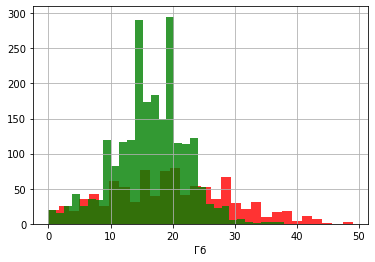

"ultra"
Медиана: 19.0
95-ый квантиль: 37.0
Среднее: 19
Дисперсия: 97
Стандартное отклонение: 10

"smart"
медиана: 17.0
95-ый квантиль: 25.0
Среднее: 16
Дисперсия: 33
Стандартное отклонение: 6


In [21]:
monthly_user_communications[monthly_user_communications['tariff'] == 'ultra']['internet_traffic'].hist(bins=30, alpha=0.8, color='r').set_xlabel('Гб')

monthly_user_communications[monthly_user_communications['tariff'] == 'smart']['internet_traffic'].hist(bins=30, alpha=0.8, color='g').set_xlabel('Гб')
plt.show()

print('"ultra"')
print('Медиана:', monthly_user_communications[monthly_user_communications['tariff'] == 'ultra']['internet_traffic'].median())
print('95-ый квантиль:', monthly_user_communications[monthly_user_communications['tariff'] == 'ultra']['internet_traffic'].quantile(0.95))
print('Среднее:', round(monthly_user_communications[monthly_user_communications['tariff'] == 'ultra']['internet_traffic'].mean()))
print('Дисперсия:', round(np.var(monthly_user_communications[monthly_user_communications['tariff'] == 'ultra']['internet_traffic'])))
print('Стандартное отклонение:', round(np.std(monthly_user_communications[monthly_user_communications['tariff'] == 'ultra']['internet_traffic'])))
print()
print('"smart"')
print('медиана:', monthly_user_communications[monthly_user_communications['tariff'] == 'smart']['internet_traffic'].median())
print('95-ый квантиль:', monthly_user_communications[monthly_user_communications['tariff'] == 'smart']['internet_traffic'].quantile(0.95))
print('Среднее:', round(monthly_user_communications[monthly_user_communications['tariff'] == 'smart']['internet_traffic'].mean()))
print('Дисперсия:', round(np.var(monthly_user_communications[monthly_user_communications['tariff'] == 'smart']['internet_traffic'])))
print('Стандартное отклонение:', round(np.std(monthly_user_communications[monthly_user_communications['tariff'] == 'smart']['internet_traffic'])))


В использовании интернета так же есть отличия:
- несмотря на небольшую разницу в медианном значении по потреблению интернета, среди пользователей тарифа "ultra" много пользователей, потребляющих большое количество интернета, что отражается на 95 квантиле- он на 12 Гб больше, чем у тарифа "smart"
- в тарифе "smart" пользователи в большинстве своем выходят за ежемесячный бесплатный пакет и оплачивают дополнительные Гб. Пользователи тарифа "ultra" чаще всего укладываются в бесплатные Гб. 


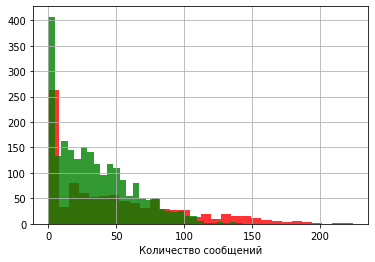

"ultra"
Медиана: 38.0
95-ый квантиль: 145.0
Среднее: 49
Дисперсия: 2283
Стандартное отклонение: 48

"smart"
Медиана: 28.0
95-ый квантиль: 88.0
Среднее: 33
Дисперсия: 796
Стандартное отклонение: 28


In [22]:
monthly_user_communications[monthly_user_communications['tariff'] == 'ultra']['masseges'].hist(bins=30, alpha=0.8, color='r').set_xlabel('Количество сообщений')

monthly_user_communications[monthly_user_communications['tariff'] == 'smart']['masseges'].hist(bins=30, alpha=0.8, color='g').set_xlabel('Количество сообщений')
plt.show()

print('"ultra"')
print('Медиана:', monthly_user_communications[monthly_user_communications['tariff'] == 'ultra']['masseges'].median())
print('95-ый квантиль:', monthly_user_communications[monthly_user_communications['tariff'] == 'ultra']['masseges'].quantile(0.95))
print('Среднее:', round(monthly_user_communications[monthly_user_communications['tariff'] == 'ultra']['masseges'].mean()))
print('Дисперсия:', round(np.var(monthly_user_communications[monthly_user_communications['tariff'] == 'ultra']['masseges'])))
print('Стандартное отклонение:', round(np.std(monthly_user_communications[monthly_user_communications['tariff'] == 'ultra']['masseges'])))
print()
print('"smart"')
print('Медиана:', monthly_user_communications[monthly_user_communications['tariff'] == 'smart']['masseges'].median())
print('95-ый квантиль:', monthly_user_communications[monthly_user_communications['tariff'] == 'smart']['masseges'].quantile(0.95))
print('Среднее:', round(monthly_user_communications[monthly_user_communications['tariff'] == 'smart']['masseges'].mean()))
print('Дисперсия:', round(np.var(monthly_user_communications[monthly_user_communications['tariff'] == 'smart']['masseges'])))
print('Стандартное отклонение:', round(np.std(monthly_user_communications[monthly_user_communications['tariff'] == 'smart']['masseges'])))

Вот тут у пользователей обоих тарифов есть больше общего:
- в обоих тарифах есть значимое число пользователей, которые вообще не пользуются отправкой сообщений
- в обоих тарифах пользователи чаще всего укладываются в бесплатный лимит. В "ultra" никто не достигает порога в 1000 сообщений, но использует эту коммуникацию активнее, чем в тарифе "smart".

## Проверка гипотез <a id='Гипотезы'></a>

### Гипотеза 1
средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;

Сформулируем нулевую и альтернативную гипотезы:

- нулевая гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» не различаются
- альтернативная гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» отличаются друг от друга

In [23]:
#сформируем выборки для анализа:
revenue_ultra = monthly_user_communications[monthly_user_communications['tariff'] == "ultra"]
revenue_smart = monthly_user_communications[monthly_user_communications['tariff'] == "smart"]

#для того, чтоб избавиться от выбросов, посмотрим на значения 25 и 75 квантиля:
print('Границы значений для тарифа "ultra":')
print(revenue_ultra['revenue'].quantile(0.25))
print(revenue_ultra['revenue'].quantile(0.95))
print('Границы значений для тарифа "smart":')
print(revenue_smart['revenue'].quantile(0.25))
print(revenue_smart['revenue'].quantile(0.95))

Границы значений для тарифа "ultra":
1950.0
3000.0
Границы значений для тарифа "smart":
550.0
2888.599999999999


In [24]:
#уберем редкие выбивающиеся значения:
revenue_ultra = revenue_ultra[(revenue_ultra['revenue'] <= 3000) & (revenue_ultra['revenue'] >= 1950)]['revenue']
revenue_smart = revenue_smart[(revenue_smart['revenue'] <= 2889) & (revenue_smart['revenue'] >= 550)]['revenue']

In [25]:
#применяем статистический тест
alpha = 0.05 

results = st.ttest_ind(
    revenue_ultra, 
    revenue_smart)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  1.30820796089857e-271
Отвергаем нулевую гипотезу


Исходя из теста делаем вывод, что средний доход в тарифах различается. 
Давайте посмотрим, в чью пользу.

In [26]:
print('средняя выручка в тарифе "ultra":',round(revenue_ultra.mean(),2))
print('средняя выручка в тарифе "smart":',round(revenue_smart.mean(),2))

средняя выручка в тарифе "ultra": 2001.27
средняя выручка в тарифе "smart": 1173.33


Пользователи тарифа "ultra" в среднем приносят больший доход компании, нежели пользователи "smart". 
Похоже, что это обусловлено большим ежемесячным плетежом. Даже несмотря на то, что пользователи "smart" не укладываются в лимиты и достаточно много доплачивают за дополнительные пакеты (больше, чем ежемесячный платеж). 

### Гипотеза 2
Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Сформулируем нулевую и альтернативную гипотезы:

нулевая гипотеза: средняя выручка пользователей Москвы и других регионов не различаются
альтернативная гипотеза: средняя выручка пользователей Москвы и других регионов отличаются друг от друга

In [27]:
#сформируем выборки для анализа:
revenue_moscow = monthly_user_communications[monthly_user_communications['city'] == "Москва"]
revenue_other = monthly_user_communications[monthly_user_communications['city'] != "Москва"]

#для того, чтоб избавиться от выбросов, посмотрим на значения 25 и 75 квантиля:
print('Границы значений для Москвы:')
print(revenue_moscow['revenue'].quantile(0.25))
print(revenue_moscow['revenue'].quantile(0.95))
print('Границы значений для остальных регионов:')
print(revenue_other['revenue'].quantile(0.25))
print(revenue_other['revenue'].quantile(0.95))

Границы значений для Москвы:
780.5
2883.0
Границы значений для остальных регионов:
750.0
2906.6000000000004


In [28]:
#уберем редкие выбивающиеся значения:
revenue_moscow = revenue_moscow[(revenue_moscow['revenue'] <= 2883) & (revenue_moscow['revenue'] >= 780)]['revenue']
revenue_other = revenue_other[(revenue_other['revenue'] <= 2907) & (revenue_other['revenue'] >= 750)]['revenue']


In [29]:
#применяем статистический тест
alpha = 0.05 

results = st.ttest_ind(
    revenue_moscow, 
    revenue_other)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.057342037108214776
Не получилось отвергнуть нулевую гипотезу


Исходя из теста делаем вывод, что средняя выручка в Москве значимо не отличается от выручки в регионах.
Давайте посмотрим на само среднее:

In [30]:
print('средняя выручка в Москве:',round(revenue_moscow.mean(),2))
print('средняя выручка в других регионах:',round(revenue_other.mean(),2))

средняя выручка в Москве: 1761.87
средняя выручка в других регионах: 1711.15


Получили разницу в 50 рублей - вряд ли это могло бы стать статистически значимым. 

# Выводы <a id='Выводы'></a>

- поведение пользователей двух предоставленных тарифов отличается. Зная об особенностях повдения, можно улучшать тарифы. Например, пользователи тарифа "ultra" редко выговаривают пакет минут для телефонных разговоров, а обозначеный тарифом лимит смс не используется ни в одном из тарифов. Зная это, можно предложить компании "Мегалайн" устанавливать безлимитные звонки и смс для данного или для нового тарифа на основе "ultra" - это может быть хорошим маркетинговым преимуществом, без дополнитлеьных затрат. 
- более дорогой тариф "ultra" приносит большую выручку компании. Однако, в данный момент пользователей данного тарифа в два раза меньше, чем "smart". Если есть задача выбрать для промотирования один из данных тарифов, то выбор стоит сделать в пользу "ultra". 
- пользователи Москвы и других регионов значимо не отличаются в плане выручки. Поэтому особо продвигать тариф в рамках столицы не имеет смысла. 